На предложенном датасете с помощью библиотеки libsvm была решена задача классификации спама. Исходный код и графики ниже.

Степени $k$ лежат в диапазоне $[-5,\,20]$. Из результатов запусков можно сделать вывод, что при увеличении $k$ средняя ошибка и среднеквадратичное отклонение падают, но, начиная с некоторого момента, происходит их рост (особенно это видно на графике k-fold при $d=1$ и $k=20$ - резкий рост ошибки и среднеквадратичного отклонения; также эффект виден и при $d=3$, а при четных $d$ ошибка начала увеличиваться без увеличения отклонения). Имеем явление переобучения. 

Также при увеличении $k$ (и, соответственно, $C$) и $d$ уменьшается число опорных векторов (см. результат кросс-валидации ниже).

In [1]:
import subprocess
import re
import matplotlib.pyplot as plt

def read_dataset(filename):
    X = []
    Y = []
    with open(filename, 'r') as f:
        for line in f:
            line_splitted = line.split(',')
            X.append([float(i) for i in line_splitted[:-1]])
            Y.append(int(line_splitted[-1]))
    return X, Y


def convert_to_libsvm_format(X, Y, output_file):
    with open(output_file, 'w') as f:
        for Y_X in zip(Y, X):
            x_line = " ".join(["".join([str(i_x[0]), ":", str(i_x[1])]) for i_x in enumerate(Y_X[1], start=1)])
            line = " ".join([str(Y_X[0]), x_line])
            f.write(line + "\n")
            

def convert_from_libsvm_format(input_file):
    Y = []
    X = []
    with open(input_file, 'r') as f:
        for line in f:
            splitted_line = line.strip().split(' ')
            
            Y.append(int(splitted_line[0]))
            
            x_line = []            
            for s in splitted_line[1:]:
                x_item = s.split(":")[-1]
                x_line.append(float(x_item))
            
            X.append(x_line)
            
    return X, Y
                
            
            

def libsvm_scale(input_file, output_file, scale_file, to_restore):

    if not to_restore:
        command = "svm-scale -s {0} {1} > {2}".format(scale_file, input_file, output_file)
    else:
        command = "svm-scale -r {0} {1} > {2}".format(scale_file, input_file, output_file)
        
    print command
    print subprocess.call(command, shell=True)
       
        
def get_plot_kc(avg_risk_history, plot_title):
    for d in avg_risk_history:
        kc_list = avg_risk_history[d][0]
        avg_risk_list = avg_risk_history[d][1]
        std_dev_plus_list = avg_risk_history[d][2]
        std_dev_minus_list = avg_risk_history[d][3]
        
        plt.title("{0}, d={1}".format(plot_title, d))
        plt.xlabel('k')
        plt.ylabel('error')
        
        plt.plot(kc_list, avg_risk_list, 'ro', kc_list, std_dev_plus_list, 'bo',
                 kc_list, std_dev_minus_list, 'bo', ms=1.5)
        plt.ylim([0, 0.5])
        plt.show()
        

def get_plot_d_risk(avg_risk_history, plot_title):
    d_list = []
    avg_risk_list = []
    
    for d in avg_risk_history:
        d_list.append(d)
        avg_risk_list.append(avg_risk_history[d][1][0])
        
    plt.title(plot_title + ": error")
    plt.xlabel('d')
    plt.ylabel('error')
    plt.ylim([0, 0.5])
    plt.plot(d_list, avg_risk_list, 'bo', ms=1.5)
    plt.show()
    
    
def get_plot_d_sv(avg_risk_history, plot_title):
    d_list = []
    sv_list = []
    
    for d in avg_risk_history:
        d_list.append(d)
        sv_list.append(avg_risk_history[d][4][0])
        
    plt.title(plot_title + ": support vectors")
    plt.xlabel('d')
    plt.ylabel('sv')
    plt.plot(d_list, sv_list, 'ro', ms=1.5)
    plt.show()


In [2]:
import svmutil as libsvm
import math
import sys
import numpy as np

def k_fold(X, Y, k, kc_range, d_range):
    block_size = int(math.floor(float(len(Y)) / k))
    
    min_avg_risk = 1
    min_kc = 0
    min_d = 0
    
    avg_risk_history = dict()
   
    for d in d_range:        
        for kc in kc_range:
            risk_history = []
            sv_history = []
                
            for ind in xrange(0, len(Y), block_size):
                fold_test_Y = Y[ind : min(ind + block_size, len(X))]
                fold_train_Y = list(Y[:ind])
                fold_train_Y.extend(Y[min(ind + block_size, len(Y)):])
                fold_test_X = X[ind : min(ind + block_size, len(X))]
                fold_train_X = list(X[:ind])
                fold_train_X.extend(X[min(ind + block_size, len(X)):])            
                
                C = 2 ** kc
                prob = libsvm.svm_problem(fold_train_Y, fold_train_X)
                param = libsvm.svm_parameter("-s 0 -t 1 -d {0} -c {1}".format(d, C))
                trained_model = libsvm.svm_train(prob, param)

                p_label, p_acc, p_val = libsvm.svm_predict(fold_test_Y, fold_test_X, trained_model)

                risk_history.append((100 - p_acc[0]) / 100)
                sv_history.append(trained_model.l)

            avg_risk = np.average(risk_history)
            std = np.sqrt(np.average([(x - avg_risk) ** 2 for x in risk_history]))
            avg_sv = np.average(sv_history)
        
            print "d={0}, kc={1}:\n avg_risk={2}, avg_std={3}, avg_sv={4}".format(d, kc, avg_risk, std, avg_sv)
            
            if min_avg_risk > avg_risk:
                min_avg_risk = avg_risk
                min_kc = kc
                min_d = d
            
            if d not in avg_risk_history:
                avg_risk_history[d] = [[kc], [avg_risk], [avg_risk + std], [avg_risk - std], [avg_sv]]
            else:
                avg_risk_history[d][0].append(kc)
                avg_risk_history[d][1].append(avg_risk)
                avg_risk_history[d][2].append(avg_risk + std)
                avg_risk_history[d][3].append(avg_risk - std)
                avg_risk_history[d][4].append(avg_sv)
    
    return min_kc, min_d, min_avg_risk, avg_risk_history


def test(X, Y, k, kc, d_range, X_train, Y_train):
    avg_risk_history = dict()
    
    for d in d_range:        
        
        min_C = 2 ** kc
        prob = libsvm.svm_problem(Y_train, X_train)
        param = libsvm.svm_parameter("-s 0 -t 1 -d {0} -c {1}".format(d, min_C))
        trained_model = libsvm.svm_train(prob, param)
        
        p_label, p_acc, p_val = libsvm.svm_predict(Y, X, trained_model)

        avg_risk = (100 - p_acc[0]) / 100
        avg_sv = trained_model.l

        if d not in avg_risk_history:
            avg_risk_history[d] = [[kc], [avg_risk], [], [], [avg_sv]]
        else:
            avg_risk_history[d][0].append(kc)
            avg_risk_history[d][1].append(avg_risk)
            avg_risk_history[d][4].append(avg_sv)

    return avg_risk_history


In [3]:
TRAIN_SIZE = 3450
Y_ZERO = 0
Y_ONE = 1
K = 10
KC_RANGE = xrange(-5, 21, 1)
D_RANGE = xrange(1, 5, 1)

dataset_file = "spambase.data.shuffled"

libsvm_file_train = "spambase.libsvm.train"
libsvm_file_test = "spambase.libsvm.test"
libsvm_scaled_file_train = "spambase.libsvm.scaled.train"
libsvm_scaled_file_test = "spambase.libsvm.scaled.test"
libsvm_scale_file = "spambase.train.scale"

X, Y = read_dataset(dataset_file)

X_train = X[:TRAIN_SIZE]
X_test = X[TRAIN_SIZE:]
Y_train = Y[:TRAIN_SIZE]
Y_test = Y[TRAIN_SIZE:]

convert_to_libsvm_format(X_train, Y_train, libsvm_file_train)
libsvm_scale(libsvm_file_train, libsvm_scaled_file_train, libsvm_scale_file, False)

convert_to_libsvm_format(X_test, Y_test, libsvm_file_test)
libsvm_scale(libsvm_file_test, libsvm_scaled_file_test, libsvm_scale_file, True)

X_sc_train, Y_sc_train = convert_from_libsvm_format(libsvm_scaled_file_train)
X_sc_test, Y_sc_test = convert_from_libsvm_format(libsvm_scaled_file_test)


svm-scale -s spambase.train.scale spambase.libsvm.train > spambase.libsvm.scaled.train
0
svm-scale -r spambase.train.scale spambase.libsvm.test > spambase.libsvm.scaled.test
0


In [4]:
min_kc, min_d, min_avg_risk, avg_risk_history = k_fold(X_sc_train, Y_sc_train, K, KC_RANGE, D_RANGE)

Accuracy = 61.4493% (212/345) (classification)
Accuracy = 60.8696% (210/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 64.6377% (223/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 63.4783% (219/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 54.4928% (188/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
d=1, kc=-5:
 avg_risk=0.392753623188, avg_std=0.0261271831555, avg_sv=2439.8
Accuracy = 61.4493% (212/345) (classification)
Accuracy = 60.8696% (210/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 64.6377% (223/345) (classification)
Accuracy = 62.3188% (215/345) (classification)
Accuracy = 63.4783% (219/345) (classification)
Accuracy = 60.5797% (209/345) (classification)
Accuracy = 59.4203% (205/345) (classification)
Accuracy = 54.4928% (188/345) (classification)
Accuracy = 59.4203% (205/345) 

In [5]:
_, _, _, best_fold_risk_history = k_fold(X_sc_train, Y_sc_train, K, xrange(min_kc, min_kc+1), D_RANGE)

Accuracy = 90.7246% (313/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 94.2029% (325/345) (classification)
Accuracy = 94.7826% (327/345) (classification)
Accuracy = 95.0725% (328/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 92.4638% (319/345) (classification)
Accuracy = 89.8551% (309/345) (classification)
Accuracy = 93.0435% (321/345) (classification)
d=1, kc=9:
 avg_risk=0.0715942028986, avg_std=0.0155579558265, avg_sv=711.6
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 93.6232% (322/345) (classification)
Accuracy = 95.0725% (328/345) (classification)
Accuracy = 94.4928% (326/345) (classification)
Accuracy = 94.7826% (327/345) (classification)
Accuracy = 93.3333% (322/345) (classification)
Accuracy = 92.4638% (319/345) (classification)
Accuracy = 92.7536% (320/345) (classification)
Accuracy = 90.7246% (313/345) (classification)
Accuracy = 93.913% (324/345) (c

In [6]:
# testing
tested_risk_history = test(X_sc_test, Y_sc_test, K, min_kc, D_RANGE, X_sc_train, Y_sc_train)

Accuracy = 92.007% (1059/1151) (classification)
Accuracy = 92.4414% (1064/1151) (classification)
Accuracy = 92.5282% (1065/1151) (classification)
Accuracy = 93.3102% (1074/1151) (classification)


k*=9, d*=4, risk*=0.0591304347826


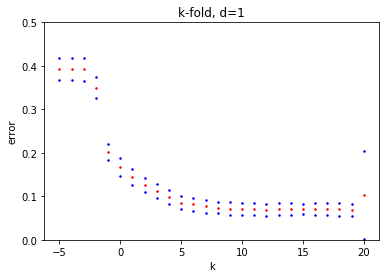

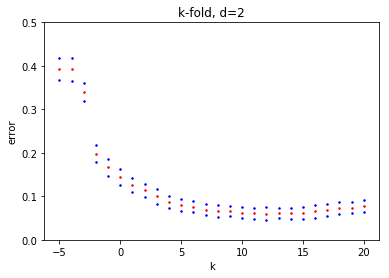

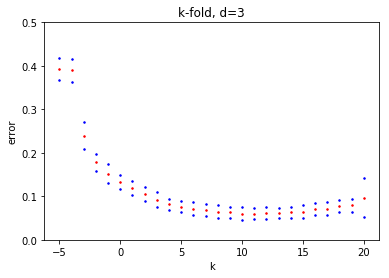

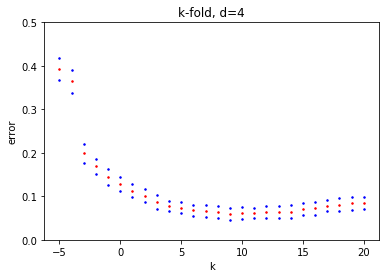

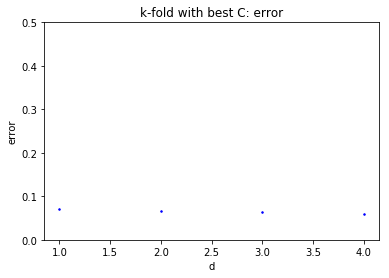

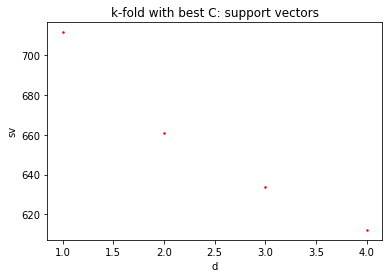

In [7]:
print "k*={0}, d*={1}, risk*={2}".format(min_kc, min_d, min_avg_risk)

get_plot_kc(avg_risk_history, "k-fold")
get_plot_d_risk(best_fold_risk_history, "k-fold with best C")
get_plot_d_sv(best_fold_risk_history, "k-fold with best C")

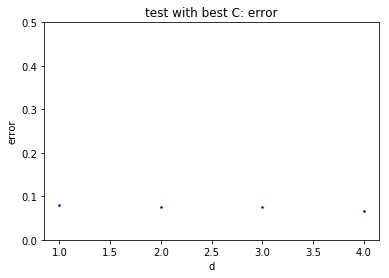

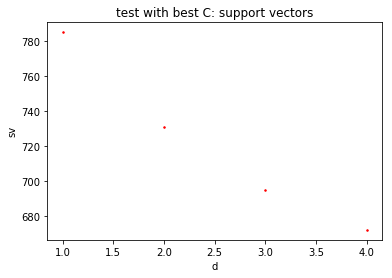

In [8]:
get_plot_d_risk(tested_risk_history, "test with best C")
get_plot_d_sv(tested_risk_history, "test with best C")